### 1. Загрузка и подготовка данных

In [28]:
import os
import json
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from tqdm.notebook import tqdm
import gensim.downloader

In [29]:
METADATA_FILE = "movie_data/combined_movies_metadata.json"
FRAMES_DIR = "movie_data/frames"
OUTPUT_DIR = "model_output"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [30]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
EMBEDDING_DIM = 300
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [31]:
print(f"Загрузка метаданных из {METADATA_FILE}")
with open(METADATA_FILE, "r", encoding="utf-8") as f:
    movies_metadata = json.load(f)

movies_with_frames = {movie_id: data for movie_id, data in movies_metadata.items()}
print(f"Найдено {len(movies_with_frames)} фильмов с кадрами")

Загрузка метаданных из movie_data/combined_movies_metadata.json
Найдено 2500 фильмов с кадрами


In [32]:
class MovieFramesDataset(Dataset):
    def __init__(self, movie_data, frames_dir, transform=None):
        self.movie_data = movie_data
        self.frames_dir = frames_dir
        self.transform = transform
        self.samples = []
        
        for movie_id, metadata in movie_data.items():
            movie_dir = os.path.join(frames_dir, str(movie_id))
            if os.path.exists(movie_dir):
                frame_files = [f for f in os.listdir(movie_dir) 
                               if f.endswith(('.jpg', '.jpeg', '.png'))]
                
                for frame_file in frame_files:
                    self.samples.append({
                        'movie_id': movie_id,
                        'frame_path': os.path.join(movie_dir, frame_file),
                        'metadata': metadata
                    })
        
        print(f"Всего доступно {len(self.samples)} кадров из {len(movie_data)} фильмов")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        movie_id = sample['movie_id']
        frame_path = sample['frame_path']
        metadata = sample['metadata']
        
        try:
            image = Image.open(frame_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Ошибка при загрузке {frame_path}: {e}")
            random_idx = random.randint(0, len(self) - 1)
            while random_idx == idx:
                random_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(random_idx)
        
        return {
            'image': image,
            'movie_id': movie_id,
            'title': metadata.get('title', ''),
            'genres': metadata.get('genres', []),
            'year': metadata.get('year', ''),
            'director': metadata.get('director', ''),
            'cast': metadata.get('cast', []),
            'path': frame_path
        }

In [33]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = MovieFramesDataset(movies_with_frames, FRAMES_DIR, transform=None)
train_indices, test_indices = train_test_split(
    range(len(full_dataset)), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(
    train_indices, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

Всего доступно 9627 кадров из 2500 фильмов


In [ ]:
def create_subset(dataset, indices, transform):
    subset = [dataset.samples[i] for i in indices]
    return MovieSubset(subset, transform)

class MovieSubset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        movie_id = sample['movie_id']
        frame_path = sample['frame_path']
        metadata = sample['metadata']
        
        try:
            image = Image.open(frame_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Ошибка при загрузке {frame_path}: {e}")
            random_idx = random.randint(0, len(self) - 1)
            while random_idx == idx:
                random_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(random_idx)
        
        return {
            'image': image,
            'movie_id': movie_id,
            'title': metadata.get('title', ''),
            'genres': metadata.get('genres', []),
            'year': metadata.get('year', ''),
            'director': metadata.get('director', ''),
            'cast': metadata.get('cast', []),
            'path': frame_path
        }

train_dataset = create_subset(full_dataset, train_indices, train_transform)
val_dataset = create_subset(full_dataset, val_indices, test_transform)
test_dataset = create_subset(full_dataset, test_indices, test_transform)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

Размер обучающей выборки: 5775
Размер валидационной выборки: 1926
Размер тестовой выборки: 1926


In [ ]:
def custom_collate_fn(batch):
    image_list = []
    movie_id_list = []
    title_list = []
    genres_list = []
    year_list = []
    director_list = []
    cast_list = []
    path_list = []
    
    for item in batch:
        image_list.append(item['image'])
        movie_id_list.append(item['movie_id'])
        title_list.append(item['title'])
        genres_list.append(item['genres'])
        year_list.append(item['year'])
        director_list.append(item['director'])
        cast_list.append(item['cast'])
        path_list.append(item['path'])
    
    images = torch.stack(image_list)
    
    return {
        'image': images,
        'movie_id': movie_id_list,
        'title': title_list,
        'genres': genres_list,
        'year': year_list,
        'director': director_list,
        'cast': cast_list,
        'path': path_list
    }

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=custom_collate_fn
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=custom_collate_fn
)

### 2. Создание текстовых эмбеддингов word2vec

In [6]:
print("Загрузка предобученной word2vec модели...")
try:
    word2vec_model = gensim.downloader.load("word2vec-google-news-300")

    with open(os.path.join(OUTPUT_DIR, 'word2vec_model.pkl'), 'wb') as f:
        pickle.dump(word2vec_model, f)
    print("Модель word2vec успешно загружена и сохранена")
except Exception as e:
    print(f"Ошибка при загрузке word2vec: {e}")
    print("Пытаемся загрузить сохраненную модель...")
    
    try:
        with open(os.path.join(OUTPUT_DIR, 'word2vec_model.pkl'), 'rb') as f:
            word2vec_model = pickle.load(f)
        print("Загружена сохраненная модель word2vec")
    except:
        print("Не удалось загрузить word2vec модель. Используем случайные эмбеддинги.")
        word2vec_model = None

Загрузка предобученной word2vec модели...
Модель word2vec успешно загружена и сохранена


In [20]:
def create_text_embeddings(movie_data, word2vec_model, embedding_dim=300):
    text_embeddings = {}
    
    for movie_id, metadata in tqdm(movie_data.items(), desc="Создание текстовых эмбеддингов"):
        title = metadata.get('title', '')
        original_title = metadata.get('original_title', '')
        overview = metadata.get('overview', '')
        genres = metadata.get('genres', [])
        director = metadata.get('director', '')
        cast = metadata.get('cast', [])
        keywords = metadata.get('keywords', [])
        
        all_words = []
        
        title_words = title.lower().split()
        original_title_words = original_title.lower().split() if original_title else []
        all_words.extend(title_words * 3)
        all_words.extend(original_title_words * 2)
        
        if overview:
            overview_words = overview.lower().split()
            all_words.extend(overview_words)
        
        all_words.extend([genre.lower() for genre in genres] * 5)
        
        if director:
            all_words.extend(director.lower().split() * 2)
        
        all_words.extend([actor.lower() for actor in cast])
        
        all_words.extend([keyword.lower() for keyword in keywords] * 3)
        
        if word2vec_model:
            word_vectors = [word2vec_model[word] for word in all_words 
                           if word in word2vec_model]
            
            if word_vectors:
                embedding = np.mean(word_vectors, axis=0)
            else:
                embedding = np.zeros(embedding_dim)
        else:
            embedding = np.random.randn(embedding_dim)
        
        if np.linalg.norm(embedding) > 0:
            embedding = embedding / np.linalg.norm(embedding)
        
        text_embeddings[movie_id] = embedding
    
    return text_embeddings

In [9]:
print("Создание текстовых эмбеддингов для фильмов...")
text_embeddings = create_text_embeddings(movies_with_frames, word2vec_model, 300)

with open(os.path.join(OUTPUT_DIR, 'text_embeddings.pkl'), 'wb') as f:
    pickle.dump(text_embeddings, f)

print(f"Текстовые эмбеддинги сохранены в {OUTPUT_DIR}/text_embeddings_full.pkl")

Создание текстовых эмбеддингов для фильмов...


Создание текстовых эмбеддингов:   0%|          | 0/2500 [00:00<?, ?it/s]

Текстовые эмбеддинги сохранены в model_output/text_embeddings_full.pkl


### 3. Модель извлечения визуальных признаков

In [ ]:
class VisualEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=300):
        super(VisualEmbeddingModel, self).__init__()
        self.backbone = models.resnet50(weights='IMAGENET1K_V2')
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.projection = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection(features)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

model = VisualEmbeddingModel(embedding_dim=EMBEDDING_DIM).to(DEVICE)
print(f"Модель создана и перемещена на {DEVICE}")

Модель создана и перемещена на cuda


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CosineEmbeddingLoss()

def get_text_embeddings_batch(batch, text_embeddings):
    movie_ids = batch['movie_id']
    batch_embeddings = []
    
    for movie_id in movie_ids:
        embedding = text_embeddings.get(movie_id, np.zeros(EMBEDDING_DIM))
        batch_embeddings.append(embedding)
    
    return torch.tensor(np.array(batch_embeddings), dtype=torch.float32).to(DEVICE)

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, text_embeddings):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Обучение"):
        images = batch['image'].to(DEVICE)
        text_emb = get_text_embeddings_batch(batch, text_embeddings)
        visual_emb = model(images)
        target = torch.ones(images.size(0)).to(DEVICE)
        loss = criterion(visual_emb, text_emb, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [ ]:
def validate(model, dataloader, criterion, text_embeddings):
    model.eval()
    total_loss = 0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    all_movie_ids = list(text_embeddings.keys())
    all_text_emb = np.array([text_embeddings[mid] for mid in all_movie_ids])
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Валидация"):
            images = batch['image'].to(DEVICE)
            text_emb = get_text_embeddings_batch(batch, text_embeddings)

            visual_emb = model(images)
            target = torch.ones(images.size(0)).to(DEVICE)
            loss = criterion(visual_emb, text_emb, target)
            total_loss += loss.item()
            
            visual_emb_np = visual_emb.cpu().numpy()
            similarities = cosine_similarity(visual_emb_np, all_text_emb)
            top5_indices = np.argsort(-similarities, axis=1)[:, :5]
            
            for i, movie_id in enumerate(batch['movie_id']):
                if movie_id == all_movie_ids[top5_indices[i, 0]]:
                    correct_top1 += 1
                
                if movie_id in [all_movie_ids[idx] for idx in top5_indices[i]]:
                    correct_top5 += 1
            
            total += images.size(0)
    
    avg_loss = total_loss / len(dataloader)
    top1_acc = correct_top1 / total
    top5_acc = correct_top5 / total
    
    return avg_loss, top1_acc, top5_acc

In [ ]:
def visualize_results(model, dataloader, text_embeddings, num_samples=5):
    model.eval()
    
    all_movie_ids = list(text_embeddings.keys())
    all_text_emb = np.array([text_embeddings[mid] for mid in all_movie_ids])
    
    movie_titles = {mid: movies_with_frames[mid].get('title', 'Unknown') 
                    for mid in all_movie_ids}
    
    all_samples = []
    for batch in dataloader:
        all_samples.extend([(img, mid, path) for img, mid, path in 
                           zip(batch['image'], batch['movie_id'], batch['path'])])
        if len(all_samples) >= num_samples:
            break
    
    samples = random.sample(all_samples, min(num_samples, len(all_samples)))
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 4 * num_samples))
    
    with torch.no_grad():
        for i, (image, movie_id, path) in enumerate(samples):
            image_tensor = image.unsqueeze(0).to(DEVICE)
            visual_emb = model(image_tensor).cpu().numpy()
            
            similarities = cosine_similarity(visual_emb, all_text_emb)[0]
            top5_indices = np.argsort(-similarities)[:5]
            
            ax = axes[i, 0]
            img = TF.to_pil_image(image * torch.tensor([0.229, 0.224, 0.225]) + 
                                 torch.tensor([0.485, 0.456, 0.406]))
            ax.imshow(img)
            ax.set_title(f"Кадр из: {movie_titles.get(movie_id, 'Unknown')}")
            ax.axis('off')
            
            ax = axes[i, 1]
            ax.barh([movie_titles.get(all_movie_ids[idx], 'Unknown') for idx in top5_indices], 
                   [similarities[idx] for idx in top5_indices])
            ax.set_title("Top-5 совпадений")
            ax.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_samples.png'))
    plt.show()

### 4. Обучение модели

In [ ]:
print(f"Начало обучения на {DEVICE}...")
best_top5_acc = 0
best_model_path = os.path.join(OUTPUT_DIR, 'best_model.pth')

history = {
    'train_loss': [],
    'val_loss': [],
    'top1_acc': [],
    'top5_acc': []
}

for epoch in range(NUM_EPOCHS):
    print(f"Эпоха {epoch+1}/{NUM_EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, text_embeddings)
    val_loss, top1_acc, top5_acc = validate(model, val_loader, criterion, text_embeddings)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['top1_acc'].append(top1_acc)
    history['top5_acc'].append(top5_acc)
    
    print(f"Потери при обучении: {train_loss:.4f}, Потери при валидации: {val_loss:.4f}")
    print(f"Top-1 точность: {top1_acc:.4f}, Top-5 точность: {top5_acc:.4f}")
    
    if top5_acc > best_top5_acc:
        best_top5_acc = top5_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Модель сохранена в {best_model_path}")

with open(os.path.join(OUTPUT_DIR, 'training_history.json'), 'w') as f:
    json.dump(history, f)

Начало обучения на cuda...
Эпоха 1/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

Валидация:   0%|          | 0/59 [00:00<?, ?it/s]

Потери при обучении: 0.3340, Потери при валидации: 0.2919
Top-1 точность: 0.0070, Top-5 точность: 0.0263
Модель сохранена в model_output/best_model.pth
Эпоха 2/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

Валидация:   0%|          | 0/59 [00:00<?, ?it/s]

Потери при обучении: 0.2915, Потери при валидации: 0.2778
Top-1 точность: 0.0279, Top-5 точность: 0.0789
Модель сохранена в model_output/best_model.pth
Эпоха 3/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

Валидация:   0%|          | 0/59 [00:00<?, ?it/s]

Потери при обучении: 0.2651, Потери при валидации: 0.2628
Top-1 точность: 0.0795, Top-5 точность: 0.1670
Модель сохранена в model_output/best_model.pth
Эпоха 4/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

Валидация:   0%|          | 0/59 [00:00<?, ?it/s]

Потери при обучении: 0.2291, Потери при валидации: 0.2546
Top-1 точность: 0.1547, Top-5 точность: 0.2809
Модель сохранена в model_output/best_model.pth
Эпоха 5/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

Валидация:   0%|          | 0/59 [00:00<?, ?it/s]

Потери при обучении: 0.1965, Потери при валидации: 0.2443
Top-1 точность: 0.2342, Top-5 точность: 0.3566
Модель сохранена в model_output/best_model.pth
Эпоха 6/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

Валидация:   0%|          | 0/59 [00:00<?, ?it/s]

Потери при обучении: 0.1691, Потери при валидации: 0.2347
Top-1 точность: 0.2954, Top-5 точность: 0.4200
Модель сохранена в model_output/best_model.pth
Эпоха 7/10


Обучение:   0%|          | 0/175 [00:00<?, ?it/s]

### 5. Демонстрация результатов работы

In [ ]:
model.load_state_dict(torch.load("/mnt/raid1/ve/moviecls/model_output_v3/best_model.pth"))

test_loss, test_top1_acc, test_top5_acc = validate(model, test_loader, criterion, text_embeddings)
print(f"Финальная оценка на тестовой выборке:")
print(f"Потери: {test_loss:.4f}")
print(f"Top-1 точность: {test_top1_acc:.4f}")
print(f"Top-5 точность: {test_top5_acc:.4f}")

Валидация:   0%|          | 0/61 [00:00<?, ?it/s]

Финальная оценка на тестовой выборке:
Потери: 0.0842
Top-1 точность: 0.8100
Top-5 точность: 0.8364


In [ ]:
def find_movie_by_frame(frame_path, model, text_embeddings, top_k=5):
    model.eval()
    
    all_movie_ids = list(text_embeddings.keys())
    all_text_emb = np.array([text_embeddings[mid] for mid in all_movie_ids])
    
    image = Image.open(frame_path).convert('RGB')
    transform = test_transform
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        visual_emb = model(image_tensor).cpu().numpy()
    
    similarities = cosine_similarity(visual_emb, all_text_emb)[0]
    
    top_k_indices = np.argsort(-similarities)[:top_k]
    
    results = []
    for idx in top_k_indices:
        movie_id = all_movie_ids[idx]
        similarity = similarities[idx]
        metadata = movies_with_frames[movie_id].copy()
        metadata['similarity'] = float(similarity)
        results.append(metadata)
    
    return results


In [ ]:
def demo_search(test_frame_path, model, text_embeddings):
    results = find_movie_by_frame(test_frame_path, model, text_embeddings)
    
    print(f"Результаты поиска для кадра: {test_frame_path}")
    for i, result in enumerate(results):
        print(f"{i+1}. {result['title']} ({result.get('year', 'N/A')})")
        print(f"   Сходство: {result['similarity']:.4f}")
        print(f"   Жанры: {', '.join(result.get('genres', []))}")
        print(f"   Режиссер: {result.get('director', 'N/A')}")
        print()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].imshow(Image.open(test_frame_path))
    axes[0].set_title("Исходный кадр")
    axes[0].axis('off')
    
    axes[1].barh([f"{r['title']} ({r.get('year', 'N/A')})" for r in results], 
               [r['similarity'] for r in results])
    axes[1].set_title("Top-5 совпадений")
    axes[1].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'search_demo.png'))
    plt.show()

Результаты поиска для кадра: /mnt/raid1/ve/moviecls/movie_data/real_frames_test/fun-new-trailer-for-the-penguins-of-madagascar.jpg
1. Человек-паук: Через вселенные (2018)
   Сходство: 0.9057
   Жанры: мультфильм, боевик, приключения, фантастика
   Режиссер: Боб Персичетти

2. Гадкий я 4 (2024)
   Сходство: 0.8539
   Жанры: мультфильм, семейный, комедия, фантастика
   Режиссер: Крис Рено

3. Суперсемейка (2004)
   Сходство: 0.7998
   Жанры: боевик, приключения, мультфильм, семейный
   Режиссер: Брэд Бёрд

4. Капитан Марвел 2 (2023)
   Сходство: 0.7869
   Жанры: фантастика, приключения, боевик
   Режиссер: Nia DaCosta

5. Дэдпул 2 (2018)
   Сходство: 0.7866
   Жанры: боевик, комедия, приключения
   Режиссер: Дэвид Литч



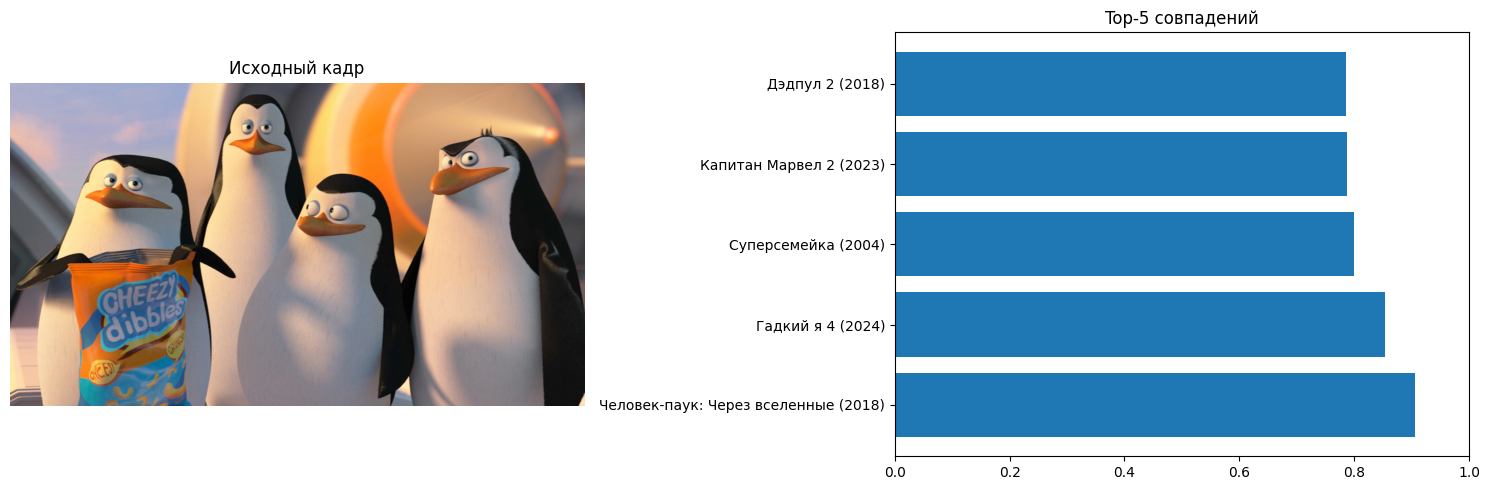

In [44]:
test_frames = ["/mnt/raid1/ve/moviecls/movie_data/real_frames_test/fun-new-trailer-for-the-penguins-of-madagascar.jpg"]

# for movie_id in random.sample(list(movies_with_frames.keys()), 3):
#     movie_dir = os.path.join(FRAMES_DIR, str(movie_id))
#     if os.path.exists(movie_dir):
#         frame_files = [f for f in os.listdir(movie_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
#         if frame_files:
#             test_frames.append(os.path.join(movie_dir, random.choice(frame_files)))

for test_frame in test_frames:
    demo_search(test_frame, model, text_embeddings)
